# Introduction / Bussiness Problem
Location is most important aspect for success of a restaurant. A not well placed location can lead to footfall and less revenue, and eventual closing down of restaurant whish will result into investor loss. Hence it s highly valuable for investor to have data driven approach while choosing a location. 

The problem statment here is to identify location characteristics across Hyderabad that can be used to judge suitability of location for opening a Restaurant.


# Data
As part of solving the problem, the Hyderabad city will be divided in squares with  city center as central point. From city center point,  Hyderabad sprawls to 15 KM each side. hence we will deivide it in 30x30 square with each block size of 1x1 sqare-km. I will use geopy library to find **coordinate of center of Hyderabad** (center Hyderabad address will be Lumbini Park). Based on the centeral coordinate, I will divide the city in blocks using algorithm. and will determine lattitude and longitude of each block. I will use **geopy library to find neibourhood name for each block**. Once neigbhourhood information is avaialble, I will use **foursquare venue API** to get the popular venues in vicinity.

Once I have all data in place (i.e. Neighbourhood name, Lattitude, Longitude, Venue Name, Venue Category etc), I will explore the data, apply ML model, evaluate the Model and will finally present result and conclusions.


# Methodology
We will identify optimal location to open a restaurant in Hyderabad. Let's first idenitfy cooridnates for Lumbini Park, The city center of Hyderabad.

In [1]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

import math

#!pip install geocoder
from geopy.geocoders import Nominatim 
import pyproj
import folium
import pandas as pd
import numpy as np

import requests # library to handle requests

import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
#find the lat, long of center point of hyderabad
center_point='Lumbini Park, Hyderabad, Telangana, India'
geolocator = Nominatim(user_agent="hyd_explorer")
location = geolocator.geocode(center_point)
print(location)
latitude = location.latitude
longitude = location.longitude

Lumbini Park, Secretariat, Ward 91 Khairatabad, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Khairatabad mandal, Hyderabad, Telangana, India


Next, Let's divide square block of 15 KM in each direction of our city center to 1x1 grid. Note that, using square is not optimal, as we will miss out venues at conerner while using Foursqaure venue API. We will address this problem in future versions. For now let's go with square only as algorithm to produce square blocks is comparatively easy. We will create block center overlapped on Hyderabad city center using Folium.

As our city center is in geographic coordinates, we will need to convert it to cartesian. Once we have cartesian coordinate of city center, we can use that information to compute cartesian coordinate of 1x1 blocks. The caretesian cooridnate of 1x1 block will converted back to geographic coordinate.

In [3]:
# create func to convert lat,long to cartesian
def convert_to_cartesian(long,lat):
    proj_latlon=pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=44, datum='WGS84')
    xy=pyproj.transform(proj_latlon, proj_xy, long, lat)
    return xy[0],xy[1]
    
    
# create func to convert cartesian point to lat, long
def convert_to_longlat(x,y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=44, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]
# computes distance between two cartesian point

def compute_distnace(x1,y1,x2,y2):
    dx=x1-x2
    dy=y1-y2
    return math.sqrt(dx*dx+dy*dt)

In [5]:
# Create neighbourhood squre blocks alogrithmacally. 
x_center,y_center=convert_to_cartesian(longitude,latitude)
x_long=[]
y_lat=[]
x_start= x_center-15000
y_start=y_center-15000
step=1000
for i in range(0,30):
    x=x_start+step*i
    for j in range(0,30):
        y=y_start+step*j
        long,lat=convert_to_longlat(x,y)
        x_long.append(long)
        y_lat.append(lat)
        
print('{} blocks generated'.format(len(x_long)))
    

900 blocks generated


In [31]:
# visulaize the data with folium

map_hyd = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Marker(location=[latitude, longitude], popup='Lumbini Park').add_to(map_hyd)
# add markers to map
for lat, lng in zip(y_lat,x_long):
    #label = '{}, {}'.format(neighborhood, borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hyd)  
    
map_hyd

Now that we have our blocks with center coordinates, We will find our neighbourhood names of block center using geopy library. We will use longitude and lattitude information for blocks.

In [63]:
#find addres with long and lat
location=geolocator.reverse("{},{}".format(y_lat[0],x_long[0]))
print(location.address)
block_adr=[]
for i,j in zip(y_lat,x_long):
    print(i,j)
    try:
        location=geolocator.reverse("{},{}".format(i,j)) 
    except:
        print("exception",i,j)
    if location is None:
        block_adr.append('Hyderabad')
    else:
        block_adr.append(location.address)
    
print("{} address".format(len(block_adr)))

Marlaguda, Kavvaguda, Shamshabad mandal, Rangareddy, Telangana, 50128, India
17.272612490141917 78.3337939163826
17.28164195113827 78.33366392919186
17.290671403074573 78.33353386346418
17.29970084594651 78.33340371918179
17.30873027974975 78.33327349632684
17.317759704479997 78.33314319488146
17.32678912013292 78.33301281482784
17.335818526704198 78.33288235614805
17.344847924189526 78.33275181882425
17.353877312584594 78.33262120283854
17.36290669188507 78.33249050817298
17.37193606208665 78.33235973480969
17.38096542318502 78.33222888273069
17.38999477517586 78.33209795191809
17.39902411805487 78.33196694235386
17.408053451817736 78.33183585402007
17.41708277646014 78.33170468689873
17.426112091977775 78.33157344097184
17.435141398366337 78.33144211622137
17.4441706956215 78.3313107126293
17.45319998373898 78.33117923017761
17.462229262714455 78.33104766884823
17.471258532543615 78.33091602862311
17.48028779322216 78.33078430948416
17.48931704474579 78.33065251141329
17.498346287110

exception 17.37280452864121 78.39818394778847
17.381834369019113 78.39805631549838
17.390864200334764 78.39792860641069
17.39989402258389 78.39780082050785
17.408923835762213 78.39767295777236
17.41795363986544 78.39754501818663
17.4269834348893 78.39741700173315
17.43601322082951 78.39728890839432
17.445042997681785 78.39716073815255
17.45407276544186 78.39703249099024
17.463102524105445 78.3969041668898
17.472132273668265 78.39677576583361
17.481162014126046 78.39664728780403
17.49019174547452 78.39651873278339
17.499221467709386 78.39639010075406
17.508251180826388 78.39626139169836
17.517280884821247 78.39613260559858
17.526310579689696 78.39600374243706
17.535340265427454 78.39587480219608
17.273597245601856 78.40898156546024
17.28262725280565 78.4088552337927
17.291657251000682 78.40872882579544
17.300687240182672 78.40860234145104
17.309717220347316 78.40847578074224
17.318747191490345 78.40834914365166
17.327777153607478 78.40822243016197
17.33680710669442 78.40809564025577
17.

17.50007483818657 78.46226334140549
17.509105019264172 78.46213788014967
17.518135191264207 78.46201234379261
17.527165354182422 78.46188673231705
17.53619550801456 78.46176104570576
17.27443585793684 78.47477476963199
17.28346633029235 78.47465163745711
17.29249679368278 78.47452843088436
17.301527248103874 78.47440514989685
17.310557693551367 78.4742817944777
17.31958813002101 78.47415836461
17.32861855750855 78.47403486027684
17.337648976009728 78.47391128146126
17.3466793855203 78.47378762814631
17.355709786036 78.47366390031507
17.36474017755259 78.47354009795053
17.37377056006581 78.47341622103573
17.382800933571414 78.47329226955368
17.391831298065146 78.47316824348736
17.40086165354276 78.47304414281976
17.409892000000003 78.47291996753384
17.41892233743263 78.47279571761256
17.4279526658364 78.47267139303885
17.436982985207067 78.47254699379569
17.44601329554036 78.47242251986596
17.45504359683206 78.47229797123256
17.464073889077916 78.47217334787841
17.47310417227368 78.4720

17.36556180630617 78.53936903699729
17.374592642466805 78.53924837974657
17.38362346966267 78.53912764986548
17.39265428788953 78.53900684733745
17.40168509714318 78.5388859721459
17.4107158974194 78.53876502427424
17.419746688713964 78.53864400370585
17.428777471022656 78.53852291042413
17.437808244341255 78.53840174441245
17.446839008665535 78.53828050565419
17.45586976399129 78.53815919413267
17.4649005103143 78.53803780983124
17.473931247630357 78.53791635273323
17.48296197593523 78.53779482282195
17.491992695224713 78.53767322008072
17.50102340549459 78.5375515444928
17.510054106740636 78.5374297960415
17.51908479895866 78.53730797471005
17.528115482144436 78.53718608048173
17.53714615629376 78.53706411333977
17.275367923519013 78.54997146030765
17.284398912866614 78.5498519857069
17.293429893297684 78.54973243891689
17.302460864808012 78.54961281992126
17.311491827393358 78.5494931287036
17.32052278104951 78.5493733652475
17.329553725772243 78.54925352953656
17.338584661557338 78

17.465705357790682 78.60390583881416
17.474736537269017 78.60378762352778
17.48376770777821 78.60366933737045
17.49279886931407 78.60355098032592
17.5018300218724 78.60343255237792
17.510861165449015 78.60331405351019
17.519892300039743 78.60319548370641
17.52892342564039 78.6030768429503
17.537954542246766 78.60295813122553
900 address


In [64]:
# Create dataframe

df_locations = pd.DataFrame({'Neighbourhood': block_adr,
                             'Latitude': y_lat,
                             'Longitude': x_long})

df_locations.to_pickle('./locations.pkl')    

In [4]:
#load data from pickle
df_locations=pd.read_pickle('./locations.pkl')

In [5]:
df_locations.head()
#test=df_locations[df_locations['Address']=='Hyderabad']
#print(test.count())
#df_locations.shape

,Address,Latitude,Longitude
0,"Marlaguda, Kavvaguda, Shamshabad mandal, Ranga...",17.272612,78.333794
1,"Nagireddyguda, Moinabad mandal, Rangareddy, Te...",17.281642,78.333664
2,"Nagireddyguda, Moinabad mandal, Rangareddy, Te...",17.290671,78.333534
3,"Bangaliguda, Nagireddyguda, Moinabad mandal, R...",17.299701,78.333404
4,"Bangaliguda, Nagireddyguda, Moinabad mandal, R...",17.308730,78.333273


Now that we have block geographic coordinates, Let's find top 100 venues in radius of 500 meter for each block. I will use Foursquare API for this purpose. Foursquare API some times does not have category information of venue, we will drop such records afterwords. 

In [30]:
# Find top 100 popular venues within neighbourhood
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius=500
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            venues_list.append([(name,lat,lng,None,None,None,None)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
hyd_venues = getNearbyVenues(names=df_locations['Neighbourhood'],
                                   latitudes=df_locations['Latitude'],
                                   longitudes=df_locations['Longitude']
                                  )


Marlaguda, Kavvaguda, Shamshabad mandal, Rangareddy, Telangana, 50128, India
Nagireddyguda, Moinabad mandal, Rangareddy, Telangana, 500058, India
Nagireddyguda, Moinabad mandal, Rangareddy, Telangana, 500058, India
Bangaliguda, Nagireddyguda, Moinabad mandal, Rangareddy, Telangana, 500058, India
Bangaliguda, Nagireddyguda, Moinabad mandal, Rangareddy, Telangana, 500008, India
Bangaliguda, Nagireddyguda, Moinabad mandal, Rangareddy, Telangana, 500008, India
Bangaliguda, Nagireddyguda, Moinabad mandal, Rangareddy, Telangana, 500008, India
Bangaliguda, Himayath Nagar, Moinabad mandal, Rangareddy, Telangana, 500008, India
Bangaliguda, Himayath Nagar, Moinabad mandal, Rangareddy, Telangana, 500008, India
NH163, Bangaliguda, Himayath Nagar, Moinabad mandal, Rangareddy, Telangana, 500008, India
Gandipet, Gandipet mandal, Rangareddy, Telangana, 500008, India
Gandipet, Khanapur, Gandipet mandal, Rangareddy, Telangana, 500008, India
Shanthi Nagar, Kokapet, Khanapur, Gandipet mandal, Rangareddy, 

Boulder Hills, Outer Ring Road, Telecom Nagar, Ward 105 Gachibowli, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Rangareddy, Telangana, HYDERABAD – 500032, India
Infosys, Boulder Hills Road, Telecom Nagar, Ward 105 Gachibowli, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Rangareddy, Telangana, HYDERABAD – 500032, India
International Institute of Information Technology, Hyderabad, ISB Road, Ward 105 Gachibowli, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Rangareddy, Telangana, 500032, India
Anjaiah Nagar, Ward 106 Serilingampally, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Rangareddy, Telangana, 500032, India
Manasa Residency, Masjid Banda Road, Ward 106 Serilingampally, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Rangareddy, Telangana, 500046, India
Raja Rajeshwari Nagar, Ward 104

Madhava Nagar, Ward 107 Madhapur, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Medchal–Malkajgiri, Telangana, 50, India
Kalapuram Basti, Ward 108 Miyapur, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Rangareddy, Telangana, 500049, India
Mayuri Nagar, Ward 108 Miyapur, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Rangareddy, Telangana, 500049, India
Mayuri Nagar, Ward 108 Miyapur, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Rangareddy, Telangana, 500090, India
Bachupally, Bachupally mandal, Medchal–Malkajgiri, Telangana, 500090, India
Bachupally, Bachupally mandal, Medchal–Malkajgiri, Telangana, 500090, India
Outer Ring Road, Rallaguda, Marlaguda, Kothwalguda, Shamshabad mandal, Rangareddy, Telangana, 501218, India
Rallaguda, Marlaguda, Kothwalguda, Shamshabad mandal, Rangareddy, Telangana, 501218, India
Marlaguda, Kothwalgu

Nizampet, Bachupally mandal, Medchal–Malkajgiri, Telangana, 500090, India
Nizampet, Bachupally mandal, Medchal–Malkajgiri, Telangana, 500090, India
Nizampet, Bachupally mandal, Medchal–Malkajgiri, Telangana, 500090, India
NH44, Rudra Colony, Kothwalguda, Shamshabad mandal, Rangareddy, Telangana, 501218, India
Rudra Colony, Kothwalguda, Shamshabad mandal, Rangareddy, Telangana, India
Kothwalguda, Shamshabad mandal, Rangareddy, Telangana, 500030, India
Ward 60 Rajendra Nagar, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Rajendranagar mandal, Rangareddy, Telangana, 500030, India
Hanuman Nagar, Ward 60 Rajendra Nagar, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Rajendranagar mandal, Rangareddy, Telangana, 500030, India
Hanuman Nagar, Ward 60 Rajendra Nagar, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Rajendranagar mandal, Rangareddy, Telangana, 500030, India
Teachers Colony, Ward 60 Rajendra Nagar, Greater Hyderabad Municipal Corporat

Gandhi Statue;Yellamma Banda, Ward 124 Alwyn Colony, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Quthbullapur mandal, Medchal–Malkajgiri, Telangana, 501002, India
Mahadevpur Colony, Ward 125 Gajularamaram, Greater Hyderabad Municipal Corporation North Zone, Hyderabad, Quthbullapur mandal, Medchal–Malkajgiri, Telangana, 501002, India
Mahadevpur Colony, Ward 125 Gajularamaram, Greater Hyderabad Municipal Corporation North Zone, Hyderabad, Quthbullapur mandal, Medchal–Malkajgiri, Telangana, 501002, India
Mahadevpur Colony, Ward 125 Gajularamaram, Greater Hyderabad Municipal Corporation North Zone, Hyderabad, Quthbullapur mandal, Medchal–Malkajgiri, Telangana, 501002, India
Velankanni Nagar, Shamshabad mandal, Rangareddy, Telangana, India
Shamshabad mandal, Rangareddy, Telangana, India
Sri Rama Nagar, Sathamrai, Rajendranagar mandal, Rangareddy, Telangana, 500030, India
Sri Rama Nagar, Ward 59 Mailardevpally, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, 

Don Bosco School, Borabanda Mothinagar road, Panduranga Rao Colony, Ward 117 Moosapet, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Balanagar mandal, Medchal–Malkajgiri, Telangana, 500018, India
Sardar Patel Nagar, Ward 117 Moosapet, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Kukatpally mandal, Medchal–Malkajgiri, Telangana, 500018, India
Moosapet Road - Mumbai Highway, Ward 115 Balaji Nagar, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Kukatpally mandal, Medchal–Malkajgiri, Telangana, 50, India
Prashanti Nagar, Ward 121 Kukatpally, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Kukatpally mandal, Medchal–Malkajgiri, Telangana, 50, India
Prakash Nagar, Ward 121 Kukatpally, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Kukatpally mandal, Medchal–Malkajgiri, Telangana, 50, India
Ward 126 Jagathgirigutta, Greater Hyderabad Municipal Corporation North Zone, Hyderabad, Kukatpally mandal, Medchal–Malkajgiri, 

Sri Ram Nagar Colony, Ward 93 Banjara Hills, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Shaikpet mandal, Hyderabad, Telangana, 500034, India
Cafe Mocha, Banjara Hills Road Number 7, Vimal Nagar, Ward 92 Venkateshwara Colony, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Shaikpet mandal, Hyderabad, Telangana, 500034, India
Nagarjuna Hills, Ward 92 Venkateshwara Colony, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Khairatabad mandal, Hyderabad, Telangana, 500073, India
Aditya Enclave, Ameerpet Road - Panjagutta Main Road, Yellareddyguda, Ward 97 Somajiguda, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Khairatabad mandal, Hyderabad, Telangana, 500018, India
Srinivas Nagar, Ward 98 Ameerpet, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Ameerpet mandal, Hyderabad, Telangana, 500038, India
Shivaji Nagar, Ward 100 Sanath Nagar, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, B

Fateh Darwaza, Ward 53 Doodh Bowli, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Bahadurpura mandal, Hyderabad, Telangana, 500064, India
Ghansi Bazaar, Ward 52 Puranapool, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Bahadurpura mandal, Hyderabad, Telangana, 500064, India
Chudi Bazaar, Ward 50 Begum Bazar, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Nampally mandal, Hyderabad, Telangana, 500012, India
Goshamahal Road, Ward 76 Mallepally, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Nampally mandal, Hyderabad, Telangana, 500002, India
Bazaar Ghat, Ward 76 Mallepally, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Nampally mandal, Hyderabad, Telangana, 500002, India
Red Hills, Ward 75 Red Hills, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Nampally mandal, Hyderabad, Telangana, 500004, India
Secretariat, Ward 91 Khairatabad, Greater Hyderabad Municipal Corporation Central Zo

Krishna Reddy Nagar, Ward 44 Uppuguda, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Bandlaguda mandal, Hyderabad, Telangana, 500005, India
Bhavani Nagar, Ward 35 Gowlipura, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Bandlaguda mandal, Hyderabad, Telangana, 500065, India
Ward 34 Talab Chanchalam, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Charminar mandal, Hyderabad, Telangana, 500065, India
Purani Haveli, \, Dar-Ul-Shifa, Ward 32 Patthergatti, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Charminar mandal, Hyderabad, Telangana, 500024, India
Imlibun, Ward 30 Dabeerpura, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Nampally mandal, Hyderabad, Telangana, 500012, India
turrebhaz khan road, Sultan Bazar, Ward 78 Gunfoundry, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Nampally mandal, Hyderabad, Telangana, 500 095, India
Boggulakunta, Ward 78 Gunfoundry, Greater Hyderabad Munici

Ward 41 Kanchanbagh, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Bandlaguda mandal, Hyderabad, Telangana, 500058, India
Ward 41 Kanchanbagh, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Bandlaguda mandal, Hyderabad, Telangana, 500058, India
Jawahar Nagar Colony, Ward 39 Santhosh Nagar, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Bandlaguda mandal, Hyderabad, Telangana, 500065, India
Banu Nagar, Ward 37 Kurmaguda, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Saidabad mandal, Hyderabad, Telangana, 500065, India
Akbarbagh, Ward 27 Akbarbagh, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Saidabad mandal, Hyderabad, Telangana, 500065, India
MCH Colony, Ward 26 Old Malakpet, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Amberpet mandal, Hyderabad, Telangana, 500024, India
Wahed Nagar, Ward 26 Old Malakpet, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Amberpet mandal, 

Dhani Nagar, Ward 38 IS Sadan, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Saroornagar mandal, Rangareddy, Telangana, 500659, India
Singareni Colony, Ward 38 IS Sadan, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Saidabad mandal, Hyderabad, Telangana, 500659, India
Bank Colony, Ward 24 Saidabad, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Saroornagar mandal, Rangareddy, Telangana, 50003, India
Salivahana Nagar, Ward 25 Moosarambagh, Greater Hyderabad Municipal Corporation South Zone, Hyderabad, Saroornagar mandal, Rangareddy, Telangana, 5000036, India
Azad Nagar, Ward 83 Amberpet, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Amberpet mandal, Hyderabad, Telangana, 5000036, India
Akash Nagar, Ward 83 Amberpet, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Amberpet mandal, Hyderabad, Telangana, 500013, India
DD Colony, Ward 84 Bagh Amberpet, Greater Hyderabad Municipal Corporation Central Zone, 

lane number 5, Sai Chitra Nagar, Ward 8 Habsiguda, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500013, India
Ravindra Nagar, Ward 8 Habsiguda, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500007, India
Osmania University, Ward 8 Habsiguda, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500007, India
VIjaya Dairy, Ward 143 Tarnaka, Greater Hyderabad Municipal Corporation North Zone, Hyderabad, Maredpally mandal, Hyderabad, Telangana, 500017, India
Ward 143 Tarnaka, Greater Hyderabad Municipal Corporation North Zone, Hyderabad, Maredpally mandal, Hyderabad, Telangana, 500017, India
Durga Nagar, Ward 140 Malkajgiri, Greater Hyderabad Municipal Corporation North Zone, Hyderabad, Malkajgiri mandal, Medchal–Malkajgiri, Telangana, 50004, India
Vishnupuri Colony, Ward 140 Malkajgiri, Greater Hyderabad Municipal 

Visalandhra Colony, Ward 11 Nagole, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Saroornagar mandal, Rangareddy, Telangana, 500068, India
Sai Nagar, Ward 11 Nagole, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500068, India
Nagole Petrol Bunk, Inner Ring Road, Ananda Nagar, Ward 11 Nagole, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500060, India
Inner Ring Road, Ward 21 Kothapet, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500060, India
Church Colony, Ward 10 Uppal, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500060, India
Ward 8 Habsiguda, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500060, India
Road No 1, Raghavendra Nagar Colony, Ward 7 Chilka Nagar, Great

Auto Nagar, Ward 12 Mansoorabad, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Saroornagar mandal, Rangareddy, Telangana, 500070, India
Geological Survey of India, Street number 7, South End Park, Ward 11 Nagole, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Saroornagar mandal, Rangareddy, Telangana, 500068, India
Mallikarjuna Nagar, Ward 11 Nagole, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500068, India
Bandlaguda, Ward 11 Nagole, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500068, India
Water Treatment Plant, Nagole Jaipur Colony Main Road, Weaker Section Colony, Ward 11 Nagole, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telangana, 500060, India
Santhi Nagar, Ward 10 Uppal, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Uppal mandal, Medchal–Malkajgiri, Telang

Peerzadiguda Government High School, Peerzadiguda Main Road, Parvathapuram, Peerzadiguda, Medipally mandal, Medchal–Malkajgiri, Telangana, 500098, India
Sai Nagar Colony Road, Sankar Nagar, Peerzadiguda, Chengicherla, Medipally mandal, Medchal–Malkajgiri, Telangana, 500098, India
Boudha Nagar, Boduppal, Chengicherla, Medipally mandal, Medchal–Malkajgiri, Telangana, 500098, India
Sri Lakshmi Nagar Colony, Boduppal, Chengicherla, Medipally mandal, Medchal–Malkajgiri, Telangana, 500092, India
Maruthi Nagar, Boduppal, Chengicherla, Medipally mandal, Medchal–Malkajgiri, Telangana, 500092, India
Maruthi Nagar, Boduppal, Chengicherla, Medipally mandal, Medchal–Malkajgiri, Telangana, 500092, India
BN Reddy Nagar, Ward 3 Cherlapally, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Medipally mandal, Medchal–Malkajgiri, Telangana, 500092, India
BN Reddy Nagar, Ward 3 Cherlapally, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Kapra mandal, Medchal–Malkajgiri, Telangan

In [52]:
#load venue data to pickle
hyd_venues.to_pickle('./hyd_venues.pkl')   
hyd_venues.shape

(1890, 7)

In [6]:
#load data from pickle
hyd_venues=df_locations=pd.read_pickle('./hyd_venues.pkl')

In [7]:
hyd_venues_nn=hyd_venues.dropna(axis=0)
hyd_venues_nn.shape

(1517, 7)

We have go total 1517 venues with category. Now, Let's see a histogram distribution to see distribution of venues neigbhourhood.

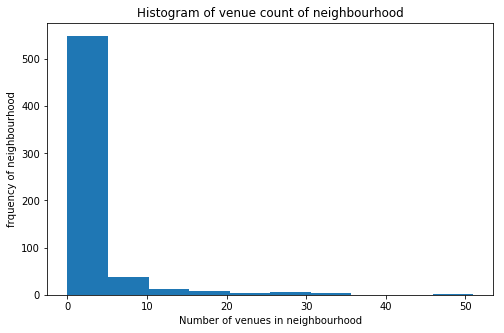

In [8]:
#plot histogram chart of venue count

hyd_venues_count=hyd_venues.groupby('Neighbourhood').count()

hyd_venues_count['Venue'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of venue count of neighbourhood') # add a title to the histogram
plt.ylabel('frquency of neighbourhood') # add y-label
plt.xlabel('Number of venues in neighbourhood') # add x-label

plt.show()

From the historgram above, Its evident that most of the neighbourhood has 10 or less venues. This indicates a lack of data for such neighbourhood and hence let's discard them now.

In [9]:
#remove location with less than 10 popular venues.
venue_limit=10
hyd_venues_count.head()
hyd_less_venue=hyd_venues_count[hyd_venues_count['Venue']<10]
hyd_less_venue=hyd_less_venue.reset_index(drop=False)
hyd_less_venue.shape

hyd_venues_trunc=hyd_venues[~hyd_venues['Neighbourhood'].isin(hyd_less_venue['Neighbourhood'])]
print(hyd_venues_trunc.shape)
hyd_venues_trunc.head()

(714, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
71,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",17.417334,78.350516,Domino's Pizza,17.418600,78.348195,Pizza Place
72,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",17.417334,78.350516,Subway,17.419278,78.347612,Sandwich Place
73,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",17.417334,78.350516,Cafe Coffee Day,17.418786,78.347679,Café
74,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",17.417334,78.350516,Waverock Cafeteria,17.418998,78.348175,Food Court
75,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",17.417334,78.350516,Axis Bank ATM,17.420349,78.350220,ATM


In [10]:
#plot bar chart of venue count

hyd_venues_trunc_count=hyd_venues_trunc.groupby('Neighbourhood').count()
hyd_venues_trunc_count=hyd_venues_trunc_count.sort_values(by=['Venue'])
print(hyd_venues_trunc_count.shape)


(37, 6)


We are now left with potentially 37 neighbourhood to choose from. Let's see the venue distribution across these neighbourhood.

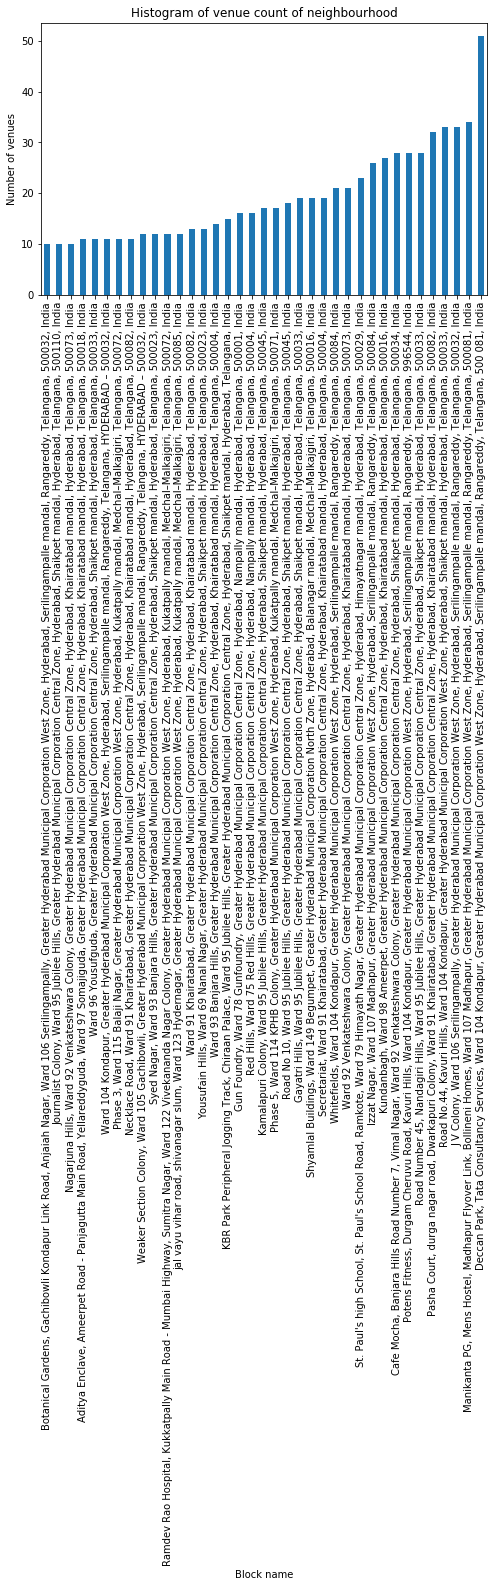

In [11]:
hyd_venues_trunc_count['Venue'].plot(kind='bar', figsize=(8, 5))

plt.title('Histogram of venue count of neighbourhood') # add a title to the histogram
plt.ylabel('Number of venues') # add y-label
plt.xlabel('Block name') # add x-label

plt.show()

From the above chart, we can see that Kondapur and Madhapur have more venues, and Gernoulist colony and Serilingampally has relatively less venues.

Now that we have data in good shape, we need decide on our model. Most important feature in our data are Category of venue and their neighbourhood. We need to label our neighbourhood data. Classfication and Clustering are two ways to lavel such data. Classficiation is supervised algorithm and requires training data which we don't have. Hence we will go with Clustering appraoch. We will try kmeans clustering algorithm and choose optimal k using elbow method.

In [12]:
#Analayze neigbourhood
# one hot encoding
hyd_onehot = pd.get_dummies(hyd_venues_trunc[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hyd_onehot['Lattitude'] = hyd_venues_trunc['Neighbourhood Latitude'] 
hyd_onehot['Longitude'] = hyd_venues_trunc['Neighbourhood Longitude'] 
hyd_onehot['Neighbourhood'] = hyd_venues_trunc['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [hyd_onehot.columns[-1],hyd_onehot.columns[-2],hyd_onehot.columns[-3]] + list(hyd_onehot.columns[:-3])
hyd_onehot = hyd_onehot[fixed_columns]

hyd_onehot.head()


,Neighbourhood,Longitude,Lattitude,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Arts & Crafts Store,...,Supermarket,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wings Joint,Women's Store
71,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",78.350516,17.417334,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",78.350516,17.417334,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",78.350516,17.417334,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",78.350516,17.417334,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,"Weaker Section Colony, Ward 105 Gachibowli, Gr...",78.350516,17.417334,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
hyd_grouped = hyd_onehot.groupby('Neighbourhood').mean().reset_index()
hyd_grouped.shape

(37, 133)

In [14]:
hyd_grouped.head()

,Neighbourhood,Longitude,Lattitude,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Arts & Crafts Store,...,Supermarket,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wings Joint,Women's Store
0,"Aditya Enclave, Ameerpet Road - Panjagutta Mai...",78.444325,17.436623,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,"Botanical Gardens, Gachibowli Kondapur Link Ro...",78.359402,17.453577,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Cafe Mocha, Banjara Hills Road Number 7, Vimal...",78.444576,17.418562,0.0,0.0,0.0,0.035714,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,"Deccan Park, Tata Consultancy Services, Ward 1...",78.378346,17.444796,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.019608,0.0,0.0,0.0,0.0,0.0,0.0,0.019608,0.0
4,"Gayatri Hills, Ward 95 Jubilee Hills, Greater ...",78.406696,17.436136,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
# TOop 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood',"Longitude","Lattitude"]
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = hyd_grouped['Neighbourhood']
neighborhoods_venues_sorted['Longitude'] = hyd_grouped['Longitude']
neighborhoods_venues_sorted['Lattitude'] = hyd_grouped['Lattitude']

for ind in np.arange(hyd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 3:] = return_most_common_venues(hyd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,Longitude,Lattitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aditya Enclave, Ameerpet Road - Panjagutta Mai...",78.444325,17.436623,Indian Restaurant,Hotel,Bar,Café,Diner,Breakfast Spot,Metro Station,Snack Place,Gastropub,Electronics Store
1,"Botanical Gardens, Gachibowli Kondapur Link Ro...",78.359402,17.453577,Hotel,Bar,Nightclub,Donut Shop,Indian Restaurant,Restaurant,Italian Restaurant,Garden,Department Store,Electronics Store
2,"Cafe Mocha, Banjara Hills Road Number 7, Vimal...",78.444576,17.418562,Coffee Shop,Café,Indian Restaurant,Fast Food Restaurant,Lounge,Food Court,Cupcake Shop,Hookah Bar,Performing Arts Venue,Deli / Bodega
3,"Deccan Park, Tata Consultancy Services, Ward 1...",78.378346,17.444796,Indian Restaurant,Hotel,Coffee Shop,Asian Restaurant,Italian Restaurant,Restaurant,Pizza Place,Sandwich Place,Lounge,Fast Food Restaurant
4,"Gayatri Hills, Ward 95 Jubilee Hills, Greater ...",78.406696,17.436136,Ice Cream Shop,Sporting Goods Shop,Clothing Store,Coffee Shop,Music Store,Café,Deli / Bodega,Miscellaneous Shop,Brewery,Bowling Alley


In [17]:
# Create cluster using kmeans.
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score
kclusters = 20
neighbourhoods_kmeans=hyd_grouped.drop(['Neighbourhood','Longitude','Lattitude'],1)
elbow=[]
ss=[]
for i in range(2,kclusters):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(neighbourhoods_kmeans)
    silhouette_avg = silhouette_score(neighbourhoods_kmeans, kmeans.labels_)
    ss.append(silhouette_avg)
    elbow.append(kmeans.inertia_)

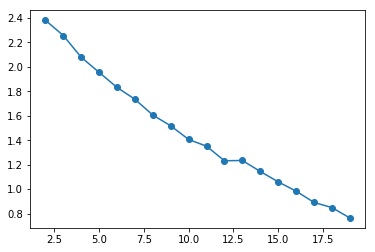

In [18]:
# elbow plot
plt.plot(range(2,kclusters),elbow,marker='o')

The elbow point is visible at k=12. We will cluster our neighbourhood with k=12. And, then will analyze each cluster by createing bar plot of 1st most common venue across cluster.

In [19]:
#elbow point at k=12
kclusters=12
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbourhoods_kmeans)
neighborhoods_venues_sorted['Cluster']=kmeans.labels_
neighborhoods_venues_sorted.head()

,Neighbourhood,Longitude,Lattitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,"Aditya Enclave, Ameerpet Road - Panjagutta Mai...",78.444325,17.436623,Indian Restaurant,Hotel,Bar,Café,Diner,Breakfast Spot,Metro Station,Snack Place,Gastropub,Electronics Store,4
1,"Botanical Gardens, Gachibowli Kondapur Link Ro...",78.359402,17.453577,Hotel,Bar,Nightclub,Donut Shop,Indian Restaurant,Restaurant,Italian Restaurant,Garden,Department Store,Electronics Store,0
2,"Cafe Mocha, Banjara Hills Road Number 7, Vimal...",78.444576,17.418562,Coffee Shop,Café,Indian Restaurant,Fast Food Restaurant,Lounge,Food Court,Cupcake Shop,Hookah Bar,Performing Arts Venue,Deli / Bodega,2
3,"Deccan Park, Tata Consultancy Services, Ward 1...",78.378346,17.444796,Indian Restaurant,Hotel,Coffee Shop,Asian Restaurant,Italian Restaurant,Restaurant,Pizza Place,Sandwich Place,Lounge,Fast Food Restaurant,1
4,"Gayatri Hills, Ward 95 Jubilee Hills, Greater ...",78.406696,17.436136,Ice Cream Shop,Sporting Goods Shop,Clothing Store,Coffee Shop,Music Store,Café,Deli / Bodega,Miscellaneous Shop,Brewery,Bowling Alley,1


In [20]:
# Create bar plot to see 1st Most popular venue distribution across cluster
df_bar_plot=neighborhoods_venues_sorted[['1st Most Common Venue','Cluster']]
df_bar_plot.set_index(['1st Most Common Venue'],inplace=True)
df_bar_plot['Cluster']=df_bar_plot['Cluster'].astype('str')

/Users/arjunagarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
df_bar_plot_onehot = pd.get_dummies(df_bar_plot[['Cluster']], prefix="Cluster-", prefix_sep="")
df_bar_plot_onehot=df_bar_plot_onehot.groupby('1st Most Common Venue').sum()
df_bar_plot_onehot.head()

,Cluster-0,Cluster-1,Cluster-10,Cluster-11,Cluster-2,Cluster-3,Cluster-4,Cluster-5,Cluster-6,Cluster-7,Cluster-8,Cluster-9
1st Most Common Venue,,,,,,,,,,,,
Asian Restaurant,0,0,0,0,0,1,0,0,0,0,0,0
Bakery,0,0,0,0,0,0,0,0,1,0,1,0
Café,0,0,1,0,0,0,0,0,1,0,0,0
Clothing Store,0,1,0,0,0,0,0,0,0,0,0,0
Coffee Shop,0,0,0,0,1,1,0,0,0,0,0,0


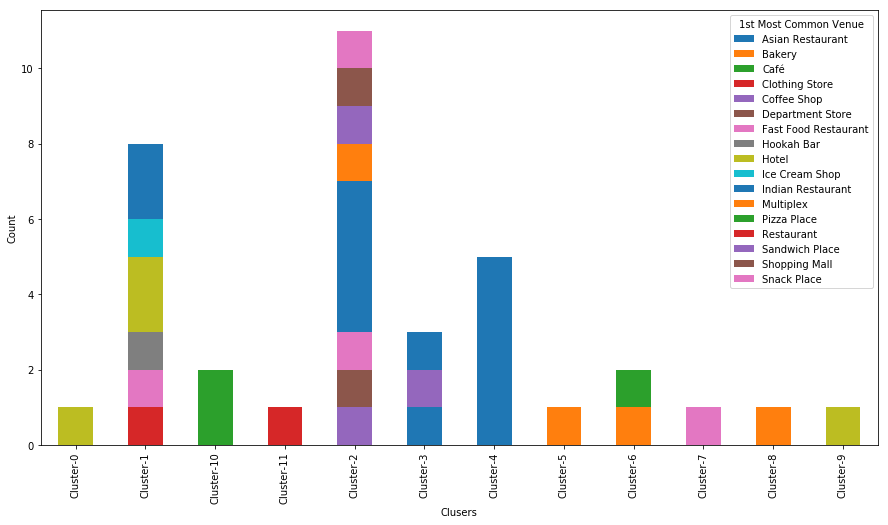

In [22]:
df_bar_plot_onehot.transpose().plot(kind='bar',figsize=(15,8),stacked=True)
plt.xlabel('Clusers')
plt.ylabel('Count')
plt.show()

Looking at above chart, following categorization of cluster type can be made
1. Cluster 0,9  - Hotels
2. Cluster 1,2 - Mix venues
3. Cluster 3,4 - Indian Restaurant
4. Cluster 5 - Multiplex
5. Cluster 7 - Snack place
6. Cluster 10 - Pizza place
7. Cluster 11 - Restaurant
8. Cluster 6,8 - Bakery

Now let's visualize the cluster on Map.

In [46]:
#Plot clustero on folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Lattitude'], neighborhoods_venues_sorted['Longitude'], neighborhoods_venues_sorted['Neighbourhood'], neighborhoods_venues_sorted['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results

Investor would like to open restaurant in unders served places or venues that attract large crowd. From our analysis Hotel and Multiplex are venues that attract large crowd. Lets look at the data from these two Type of clusters.

In [25]:
#Type -1 Hotel Cluster
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster'].isin([0,9])].head()

,Neighbourhood,Longitude,Lattitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
1,"Botanical Gardens, Gachibowli Kondapur Link Ro...",78.359402,17.453577,Hotel,Bar,Nightclub,Donut Shop,Indian Restaurant,Restaurant,Italian Restaurant,Garden,Department Store,Electronics Store,0
5,"Gun Foundry, Ward 78 Gunfoundry, Greater Hyder...",78.473168,17.391831,Hotel,Bakery,Fast Food Restaurant,Bookstore,Mobile Phone Shop,Shopping Mall,Neighborhood,Diner,Shoe Store,Fried Chicken Joint,9


In [29]:
#Type -1 Multiplex Cluster
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster'].isin([5])].head()

,Neighbourhood,Longitude,Lattitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
24,"Secretariat, Ward 91 Khairatabad, Greater Hyde...",78.463514,17.409773,Multiplex,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Movie Theater,Platform,Hotel,Vegetarian / Vegan Restaurant,Boat or Ferry,Convenience Store,5


From both above
1. The Hotel cluster has mostly mix type of venues at 2nd to 10th place of popular venue. 
2. The Multiplex cluster has one more movie theatre at 5th spot and a hotel at 7th spot. 

Hence it would make more sense to open a restaurant at Cluster 5 neighbourhoodd that is **Secretariat , Khariatabad, Hyderabad**.

# Conclusion
We did analysis of neighbourhood in Hyderabad based on Top 10 popular venues, and giving weightage to most popular veneue to identify suitable neighbourhood.
Though we came up with an answer, there is alot of sope of furhter improvement. In future we will focus on following improvement to come up with more accurate results.
1. Change block to hexagone are the one that is closer to a circle. This way we will avoid missing venues in sqaure corners.
2. Introduce restaurant score while deciding suitability of opening a restaurant in a neighbourhood. The restarunt score should factor into popularity of venue as well.
3. Introduce DBSCAN clustering algorithm that can create cluster of arbirary shape to give better result.

Thanks,